# Using PT mcmcsampler: a demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import m3c2.proposal as proposal
from m3c2.sampler import PTSampler

import multiprocessing as mp
mp.set_start_method('fork') #needed for MacOS

## Define a log-likelihood function

Here we take a simple multi dimensional Gaussian. 
We use a ```class``` to easily store all the meta data needed to evaluate the log-likelihood

In [2]:
class TestLogLik:
    """ A multi dimensional Gaussian
    """
    def __init__(self, ndim):
        """ Init number of dimensions. 
        """
        self.ndim = ndim
        self.param_dic = [f"p{i}" for i in range(ndim)]
        means = np.random.rand(ndim)
        cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
        cov = np.triu(cov)
        cov += cov.T - np.diag(cov.diagonal())
        cov = np.dot(cov, cov)
        self.mu = means
        self.cov = cov
        
    def loglik(self, x, **kwargs):
        """ Return log-likelihood for a given point x. 
        """
        diff = x - self.mu
        return -0.5 * np.dot(diff, np.linalg.solve(self.cov, diff))
    
    def logpi(self, p, **kwargs):
        """ Return log-prior for a given point x. 
        """
        return -7.0

## Define the sampler

In [3]:
# Parallel tempering parameters
Tmax = 10
Nchains = 5

# Define likelihood, priors and starting point
ndim = 3
T = TestLogLik(ndim)
priors = np.array([-3,3]*T.ndim).reshape(T.ndim,2)
x0 = [np.random.randn(T.ndim) for n in range(Nchains)]

S = PTSampler(Nchains, priors, T.loglik, T.logpi, T.param_dic, Tmax=Tmax, profiling=True)
S.set_starting_point(x0)

INFO:root:Tmax=10, range of temperature: [ 1.          1.77827941  3.16227766  5.62341325 10.        ]


## Define the proposals

In [4]:
# Define proposals
SL = proposal.Slice(T.param_dic).slice
SC = proposal.SCAM(T.param_dic).SCAM
p_dict = [{SL:40, SC:70}]*Nchains
S.set_proposals(p_dict)

## Run the sampler

In [5]:
# Run mcmc
niter = 1000
c = S.run_mcmc(niter, pSwap=0.95, printN=50, multiproc=True, n0_swap=100)

INFO:root:iter 0 chain 0
INFO:root:current loglik: -3.0, best: -3.0, temp: 1.0, ratio: 1.0
INFO:root:iter 0 chain 1
INFO:root:current loglik: -4.8, best: -4.8, temp: 1.8, ratio: 1.0
INFO:root:iter 0 chain 2
INFO:root:current loglik: -10.5, best: -10.5, temp: 3.2, ratio: 1.0
INFO:root:iter 0 chain 4
INFO:root:current loglik: -5.0, best: -5.0, temp: 10.0, ratio: 1.0
INFO:root:iter 0 chain 3
INFO:root:current loglik: -14.9, best: -14.9, temp: 5.6, ratio: 1.0
INFO:root:iter 50 chain 0
INFO:root:current loglik: -4.4, best: -3.0, temp: 1.0, ratio: 1.0
INFO:root:iter 50 chain 2
INFO:root:current loglik: -7.5, best: -5.3, temp: 3.2, ratio: 1.0
INFO:root:iter 50 chain 3
INFO:root:current loglik: -5.5, best: -1.5, temp: 5.6, ratio: 1.0
INFO:root:iter 50 chain 1
INFO:root:current loglik: -12.4, best: -4.6, temp: 1.8, ratio: 1.0
INFO:root:iter 50 chain 4
INFO:root:current loglik: -8.4, best: -4.3, temp: 10.0, ratio: 1.0
INFO:root:iter 100 chain 0
INFO:root:current loglik: -1.5, best: -0.3, temp: 1

INFO:root:iter 800 chain 0
INFO:root:current loglik: -5.8, best: -0.1, temp: 1.0, ratio: 0.41220238095238093
INFO:root:iter 800 chain 1
INFO:root:current loglik: -5.4, best: -0.0, temp: 1.7, ratio: 0.41654135338345866
INFO:root:iter 800 chain 2
INFO:root:current loglik: -20.5, best: -0.0, temp: 2.8, ratio: 0.7952522255192879
INFO:root:iter 800 chain 3
INFO:root:current loglik: -22.6, best: -0.1, temp: 4.7, ratio: 0.937592867756315
INFO:root:iter 800 chain 4
INFO:root:current loglik: -23.8, best: -2.2, temp: 10.0, ratio: 1.0
INFO:root:iter 850 chain 0
INFO:root:current loglik: -3.7, best: -0.1, temp: 1.0, ratio: 0.41307371349095967
INFO:root:iter 850 chain 1
INFO:root:current loglik: -3.3, best: -0.0, temp: 1.7, ratio: 0.3980309423347398
INFO:root:iter 850 chain 2
INFO:root:current loglik: -19.9, best: -0.0, temp: 2.8, ratio: 0.7994467496542186
INFO:root:iter 850 chain 3
INFO:root:current loglik: -19.7, best: -0.1, temp: 4.6, ratio: 0.9375
INFO:root:iter 850 chain 4
INFO:root:current lo

## Show posterior for 1st parameter

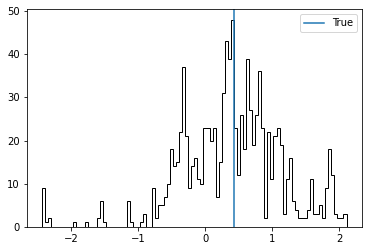

In [6]:
# Plot distribution of first parameter
#C0 = np.array(S.chains[0].chn)
C0 = np.load("chain_0.npy")[:,:-1]
plt.figure()
plt.hist(C0[:,0],  bins=100, color="k", histtype="step")
plt.axvline(x=T.mu[0], label='True')
plt.legend()

## Show likelihood evolution

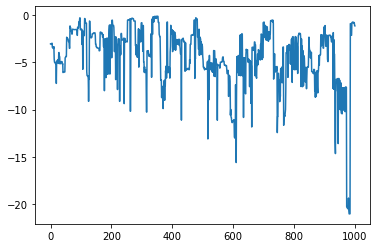

In [7]:
L = np.load("chain_0.npy")[:,-1]
plt.figure()
plt.plot(L)

## Show statistics

In [8]:
prop_names = [k.__self__.name for k,v in p_dict[0].items()]
jumps_t = np.rec.fromarrays( [np.zeros((Nchains))]*len(prop_names), names=prop_names)
ar_t = np.rec.fromarrays( [np.zeros((Nchains))]*len(prop_names), names=prop_names)
nswap = np.zeros((Nchains, 2))
for i in range(Nchains):
    s = pickle.load(open(f"stats_{i}.pkl", 'rb'))
    for n in prop_names:
        jumps_t[n][i] = s[n]['njump'] 
        ar_t[n][i] = s[n]['ar'] 
    nswap[i,0] = s["nswap_accepted"]
    nswap[i,1] = s["nswap_proposed"]

### Acceptance rate for each proposals

Text(0, 0.5, 'Number of MH steps')

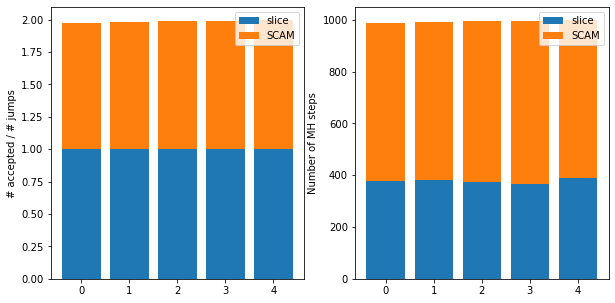

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
y_offset = np.zeros((Nchains))
for n in prop_names:
    plt.bar(np.arange(0, Nchains), height=ar_t[n]/jumps_t[n], bottom=y_offset, label=n)
    y_offset += ar_t[n]/jumps_t[n]
plt.legend()
plt.ylabel("# accepted / # jumps")

plt.subplot(122)
y_offset = np.zeros((Nchains))
for n in prop_names:
    plt.bar(np.arange(0, Nchains), height=ar_t[n], bottom=y_offset, label=n)
    y_offset += ar_t[n]
plt.legend()
plt.ylabel("Number of MH steps")

### Swap statistics

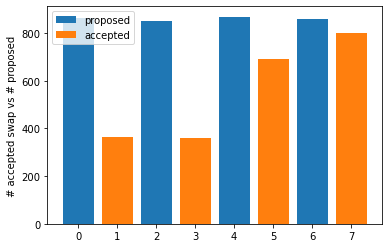

In [10]:
plt.figure()
plt.bar(np.arange(0, 2*Nchains-2, 2), height=nswap[:-1,1], label="proposed")
plt.bar(np.arange(1, 2*Nchains-1, 2), height=nswap[:-1,0], label="accepted")
plt.ylabel("# accepted swap vs # proposed")
plt.legend()